In [1]:
# ===========================================
# Task 3: Neural Networks with TensorFlow/Keras
# Dataset: Iris Classification
# Author: Houssem Eddine Bouagal
# ===========================================
!pip install --upgrade scikit-learn imbalanced-learn

# ===== 1. Imports =====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 64.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1

2025-08-31 14:56:03.296002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756652163.660634      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756652163.767048      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ===== 2. Create output directory =====
output_dir = "/kaggle/working/res-task3"
os.makedirs(output_dir, exist_ok=True)


In [3]:
# ===== 3. Load Dataset =====
data = pd.read_csv("/kaggle/input/iris-dataset/iris-dataset/iris.csv")
print("Dataset head:\n", data.head())


Dataset head:
    sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [4]:
# ===== 4. Preprocessing =====
X = data.drop(columns=["species"])  
y = data["species"]

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# SMOTE for class balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", np.bincount(y_res))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)
# Further split train into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Class distribution after SMOTE: [50 50 50]


In [5]:
# ===== 5. Build Model =====
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_res)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756652180.202110      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756652180.202828      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# ===== 6. Callbacks =====
checkpoint = ModelCheckpoint(
    os.path.join(output_dir, 'best_model.keras'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [7]:
# ===== 7. Train Model =====
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70, batch_size=16,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/70


I0000 00:00:1756652183.208361     109 service.cc:148] XLA service 0x7e04a4007120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756652183.209684     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756652183.209703     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756652183.480231     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.2500 - loss: 1.2526

I0000 00:00:1756652184.826669     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.3512 - loss: 1.1629 - val_accuracy: 0.5000 - val_loss: 1.0411
Epoch 2/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5763 - loss: 1.0216 - val_accuracy: 0.5417 - val_loss: 0.9437
Epoch 3/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6716 - loss: 0.9422 - val_accuracy: 0.7083 - val_loss: 0.8669
Epoch 4/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7768 - loss: 0.8548 - val_accuracy: 0.7500 - val_loss: 0.8043
Epoch 5/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7592 - loss: 0.8218 - val_accuracy: 0.7917 - val_loss: 0.7490
Epoch 6/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7914 - loss: 0.7247 - val_accuracy: 0.7917 - val_loss: 0.6972
Epoch 7/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8961 - loss: 0.6841 - val_accuracy: 0.7917 - val_loss: 0.6467
Epoch 8/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8774 - loss: 0.6548 - val_accuracy: 0.7917 - val_loss: 0.5989
Epoch 9/70


Train Accuracy: 0.9792,
Validation Accuracy: 0.9583,
Test Accuracy: 0.9333,

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Confusion Matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


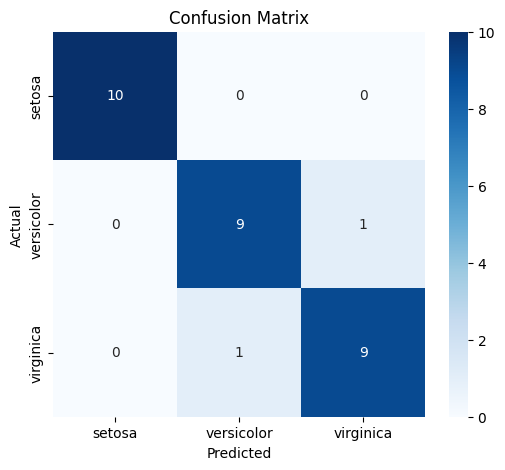

In [8]:
# ===== 8. Evaluation =====
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTrain Accuracy: {train_acc:.4f},")
print(f"Validation Accuracy: {val_acc:.4f},")
print(f"Test Accuracy: {test_acc:.4f},")

# Predictions
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# Classification Report
report = classification_report(y_test, y_pred, target_names=le.classes_)
print("\nClassification Report:\n", report)

# Save Classification Report
with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
    f.write(report)
    
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()


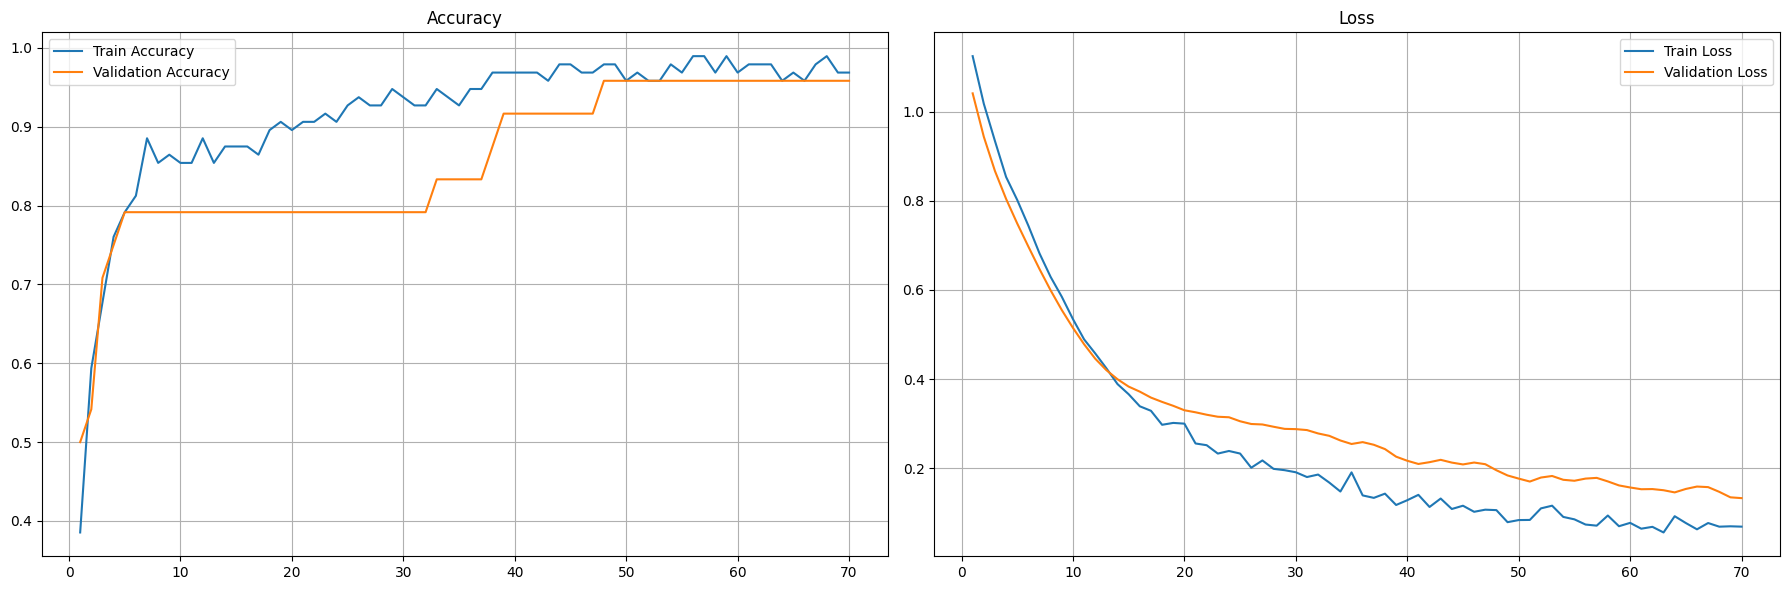


✅ All results saved'/kaggle/working/res-task3'


In [9]:

# Accuracy & Loss Curves
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.grid(True); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.grid(True); plt.title('Loss')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "metrics_curves.png"))
plt.show()

print(f"\n✅ All results saved'{output_dir}'")
